In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from geopy.geocoders import Nominatim
from time import sleep
import random
from phik import phik_matrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import (FunctionTransformer,
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   OneHotEncoder)
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
import time

In [2]:
pd.set_option('future.no_silent_downcasting', True)

Собственные функции

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Создаем RMSE scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [4]:
def top_10_frequent_values(df, columns):
    for col in columns:
        print(f"\nТоп 10 частых значений в % {col}:\n")
        top_10 = df[col].value_counts(normalize=True).head(10) * 100
        display(top_10)

In [5]:
def get_info(*dataframes):
    """
    Выводит информацию о каждом переданном DataFrame.

    Параметры:
    *dataframes (DataFrame): один или несколько DataFrame для анализа.

    Вывод:
    Для каждого DataFrame:
        - Информацию о DataFrame (df.info()).
        - Статистическое описание числовых столбцов (df.describe()).
        - Первые 5 строк DataFrame (df.head(5)).
    """
    for df in dataframes:
        df = pd.DataFrame(df)
        print('---info---', end='\n\n')
        display(df.info())
        print('---describe---', end='\n\n')
        display(df.describe())
        print('---head---', end='\n\n')
        display(df.head(5))

In [6]:
def categorize_columns(df):
    num_cols = []
    cat_cols = []
    date_cols = []
    bool_cols = []
    other_cols = []
    
    for col in df.columns:
        dtype = df[col].dtype
        if pd.api.types.is_numeric_dtype(dtype):
            num_cols.append(col)
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            date_cols.append(col)
        elif pd.api.types.is_categorical_dtype(dtype) or pd.api.types.is_object_dtype(dtype) or pd.api.types.is_string_dtype(dtype):
            cat_cols.append(col)
        elif pd.api.types.is_bool_dtype(dtype):
            bool_cols.append(col)
        else:
            other_cols.append(col)
    
    return {
        'numerical': num_cols,
        'categorical': cat_cols,
        'datetime': date_cols,
        'boolean': bool_cols,
        'other': other_cols
    }

In [7]:
def check_isna_dupl(*dataframes):
    """
    Проверяет наличие пропущенных значений, дубликатов и уникальных значений в каждом переданном DataFrame.

    Параметры:
    *dataframes (DataFrame): один или несколько DataFrame для анализа.

    Вывод:
    Для каждого DataFrame:
        - Количество пропущенных значений в каждом столбце (df.isna().sum()).
        - Количество дублирующихся строк (df.duplicated().sum()).
        - Количество уникальных значений в каждом столбце (df.nunique()).
        - Уникальные значения для столбцов с типом данных, отличным от int64 и float64.
    """
    for df in dataframes:
        print('---ISNA COUNT---', end='\n\n')
        display(df.isna().sum())
        print('---DUPL COUNT---', end='\n\n')
        display(df.duplicated().sum())
        print('---NUNIQUE---', end='\n\n')
        display(df.nunique())
        for column in df.columns:
            if df[column].dtype not in ['int64', 'float64']:
                print(f'Колонка: "{column}" и её уникальные значения: {df[column].unique()}')

In [8]:
def reverse_ordinal_encode_kilometer(df):
    """
    Функция для обратного порядкового кодирования значений в столбце Kilometer.
    Чем меньше значение пробега, тем больше порядковый номер категории.

    :param df: DataFrame с данными
    :param column_name: название столбца для кодирования
    :return: DataFrame с закодированным столбцом
    """
    # Получаем уникальные значения столбца и сортируем в порядке убывания
    unique_kilometers = df['Kilometer'].sort_values(ascending=False).unique()
    
    # Создаем словарь для обратного кодирования: чем меньше пробег, тем больше индекс
    kilometer_mapping = {value: idx for idx, value in enumerate(unique_kilometers)}
    
    # Применяем map() для замены значений в столбце
    df['Kilometer'] = df['Kilometer'].map(kilometer_mapping)
    return df

## Знакомство с данными и предобработка

In [9]:
data = pd.read_csv('autos.csv')

In [10]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [11]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Чекнем записи, где лошадиных сил 0 или они больше 0.75 квантиля

In [12]:
data[(data['Power']>400)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21 00:00:00,0,1723,2016-04-04 04:49:06
2781,2016-03-16 00:37:16,19500,suv,2004,auto,450,cayenne,125000,12,petrol,porsche,no,2016-03-16 00:00:00,0,38448,2016-04-01 22:47:31
3289,2016-03-10 17:46:47,16899,wagon,2003,auto,476,e_klasse,150000,9,petrol,mercedes_benz,no,2016-03-10 00:00:00,0,44319,2016-04-03 18:47:41
3746,2016-03-21 14:48:31,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21 00:00:00,0,49356,2016-03-24 03:44:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353493,2016-04-02 20:54:21,12500,NaN,2017,manual,2000,other,60000,0,gasoline,chrysler,no,2016-04-02 00:00:00,0,44145,2016-04-06 21:44:39
353633,2016-03-23 23:55:21,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,NaN,2016-03-23 00:00:00,0,45277,2016-03-27 01:15:17
354045,2016-03-22 20:48:48,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no,2016-03-22 00:00:00,0,38118,2016-03-24 05:16:02
354260,2016-03-09 17:59:03,399,other,1994,NaN,1103,3er,150000,0,NaN,bmw,NaN,2016-03-09 00:00:00,0,56235,2016-03-17 09:17:08


Сразу удалим записи. где даты меньше 1885 года(изобретенеи машины) и выше 2024

In [13]:
df = data.copy(deep=True)

In [14]:
df = df[(df['RegistrationYear']>1885)&(df['RegistrationYear']<2024)]

И допнем столбец "КОЛИЧЕСТВО КАРТИНОК", там одни нули

In [15]:
df = df.drop(columns=['NumberOfPictures'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354198 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354198 non-null  object
 1   Price              354198 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354198 non-null  int64 
 4   Gearbox            334503 non-null  object
 5   Power              354198 non-null  int64 
 6   Model              334568 non-null  object
 7   Kilometer          354198 non-null  int64 
 8   RegistrationMonth  354198 non-null  int64 
 9   FuelType           321431 non-null  object
 10  Brand              354198 non-null  object
 11  Repaired           283191 non-null  object
 12  DateCreated        354198 non-null  object
 13  PostalCode         354198 non-null  int64 
 14  LastSeen           354198 non-null  object
dtypes: int64(6), object(9)
memory usage: 43.2+ MB


In [17]:
df['FuelType']

0           petrol
1         gasoline
2         gasoline
3           petrol
4         gasoline
            ...   
354364      petrol
354365         NaN
354366      petrol
354367    gasoline
354368    gasoline
Name: FuelType, Length: 354198, dtype: object

In [18]:
categorize_columns(df)

C:\Users\godcl\AppData\Local\Temp\ipykernel_15560\2303519190.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dtype) or pd.api.types.is_object_dtype(dtype) or pd.api.types.is_string_dtype(dtype):


{'numerical': ['Price',
  'RegistrationYear',
  'Power',
  'Kilometer',
  'RegistrationMonth',
  'PostalCode'],
 'categorical': ['DateCrawled',
  'VehicleType',
  'Gearbox',
  'Model',
  'FuelType',
  'Brand',
  'Repaired',
  'DateCreated',
  'LastSeen'],
 'datetime': [],
 'boolean': [],
 'other': []}

5 численных признаков, 7 категориальных, 2 даты + 2 столбца с годом и месяцем регистрации

In [19]:
check_isna_dupl(df)

---ISNA COUNT---



DateCrawled              0
Price                    0
VehicleType          37319
RegistrationYear         0
Gearbox              19695
Power                    0
Model                19630
Kilometer                0
RegistrationMonth        0
FuelType             32767
Brand                    0
Repaired             71007
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

---DUPL COUNT---



4

---NUNIQUE---



DateCrawled          271080
Price                  3731
VehicleType               8
RegistrationYear         98
Gearbox                   2
Power                   711
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
PostalCode             8143
LastSeen             179084
dtype: int64

Колонка: "DateCrawled" и её уникальные значения: ['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Колонка: "VehicleType" и её уникальные значения: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Колонка: "Gearbox" и её уникальные значения: ['manual' 'auto' nan]
Колонка: "Model" и её уникальные значения: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'meg

<Axes: >

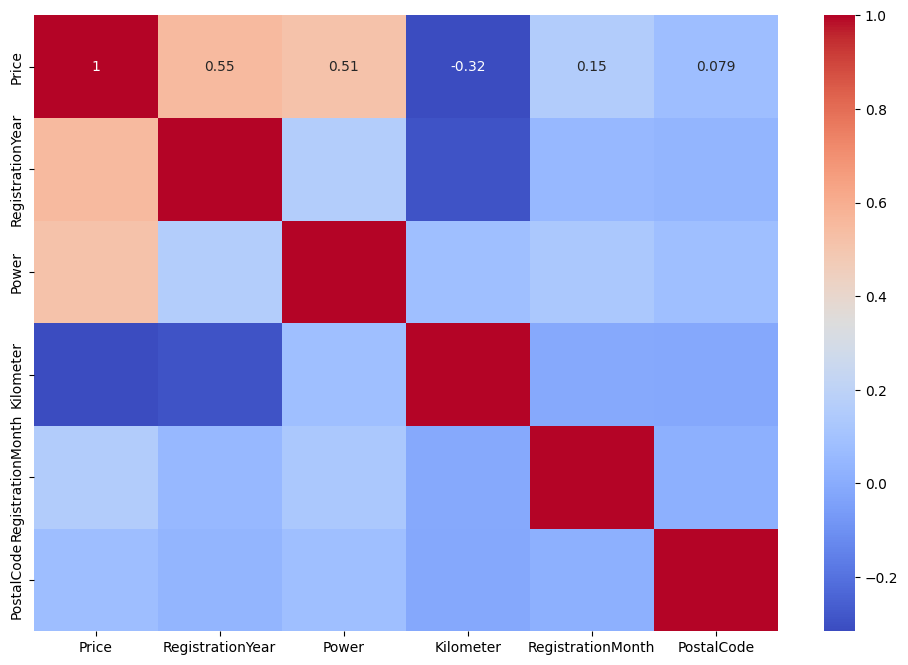

In [20]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(method='spearman',numeric_only=True),cmap='coolwarm',annot=True)

In [21]:
df.shape

(354198, 15)

Можно преобразовать даты в столбец days_between_reg_and_seen, в котором будет написано. когда зарегистрировал и когда зашёл, чтобы условно была колонка с "активностью" продавца
Чем меньше значение в колонке, тем меньше активность

Это код для перевода postal code в страну, 

но он отрабатывает за 0.3 секунды для одной записи -> 354369*0.3 = 29.5 часов работы, 

я просто удалю этот столбец, так как ничего не смогу из него вытянуть, **это дорого по времени и ресурсам**

In [22]:
df = df.drop(columns=['PostalCode'])

In [23]:
# # Инициализация геолокатора
# geolocator = Nominatim(user_agent="geoapi")

# # Кэш для хранения результатов
# cache = {}

# # Функция для получения страны с кэшированием
# def get_country_by_postal_code(postal_code):
#     # Проверяем, есть ли код в кэше
#     if postal_code in cache:
#         return cache[postal_code]
    
#     # Выполняем запрос только если его нет в кэше
#     try:
#         location = geolocator.geocode({"postalcode": postal_code})
#         if location:
#             country = location.address.split(',')[-1].strip()
#         else:
#             country = None
#     except:
#         country = None
    
#     # Сохраняем результат в кэш
#     cache[postal_code] = country
    
#     # Искусственная задержка между запросами, чтобы не перегружать сервер
#     sleep(0.1)
    
#     return country
#     df_code = df.copy(deep=True)
#     df_code['PostalCode'] = df['PostalCode'].apply(get_country_by_postal_code)

Теперь колонка Kilometer, сейчас в ней лежат инты, 

но по сути это категории, напишу функцию для "обратного" ordinalencodera, потом закину ее в дата препроцессор в пайлпайне.

In [24]:
df['Kilometer'].value_counts().shape[0]

13

In [25]:
rep_gear_rat = df.groupby(by=['Gearbox'])['Repaired'].count()
rep_kilo_rat = df.groupby(by=['Kilometer'])['Repaired'].count()

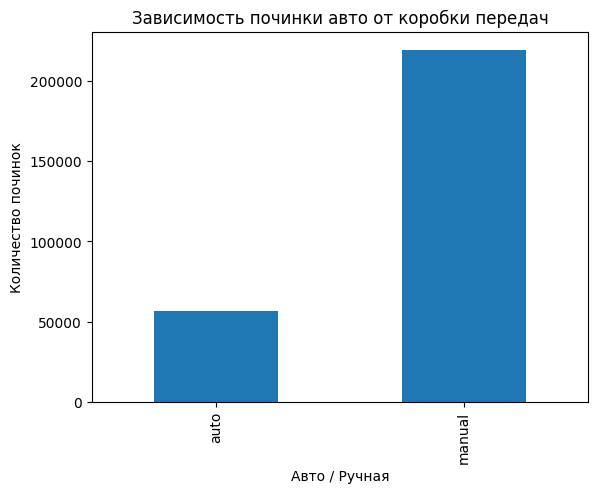

In [26]:
rep_gear_rat.plot(kind='bar',title='Зависимость починки авто от коробки передач',xlabel='Авто / Ручная',ylabel='Количество починок')
plt.show()

Посчитаем средний возраст авто с ручной и авто коробкой

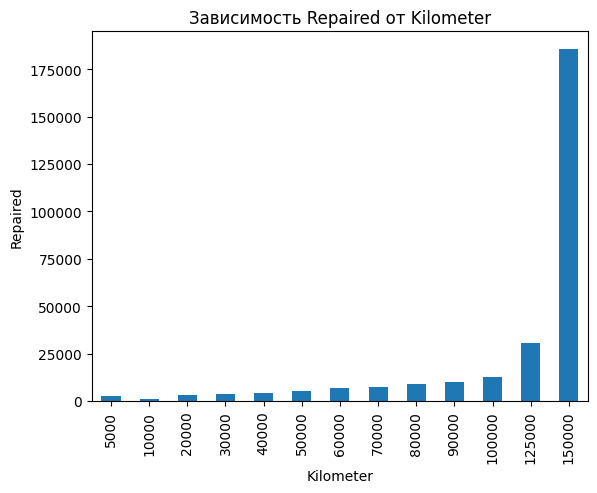

In [27]:
rep_kilo_rat.plot(kind='bar',title='Зависимость Repaired от Kilometer',xlabel='Kilometer',ylabel='Repaired')
plt.show()

In [28]:
df.groupby(['Gearbox','RegistrationYear'])['Repaired'].count().reset_index()

,Gearbox,RegistrationYear,Repaired
0,auto,1910,1
1,auto,1931,1
2,auto,1934,0
3,auto,1947,1
4,auto,1950,0
...,...,...,...
159,manual,2015,875
160,manual,2016,4216
161,manual,2017,4535
162,manual,2018,1887


In [29]:
year_rep_ratio = df.groupby(['RegistrationYear'])['Repaired'].count().reset_index()

<Axes: >

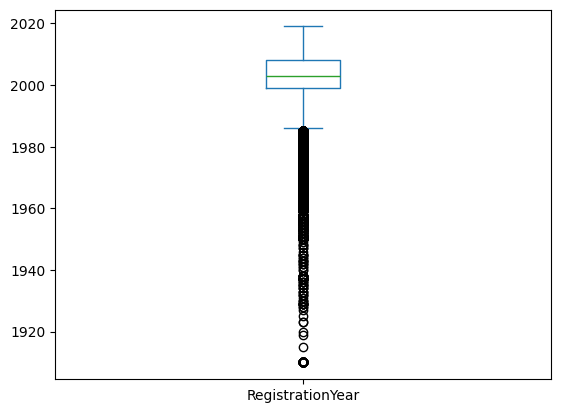

In [30]:
df['RegistrationYear'].plot(kind='box')

In [31]:
df['RegistrationYear'].describe()

count    354198.000000
mean       2003.084789
std           7.536418
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

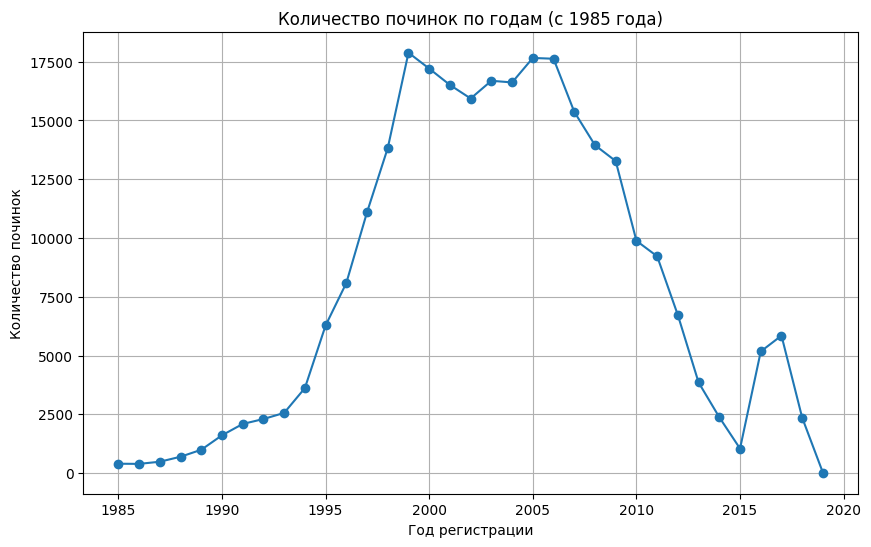

In [32]:
# Фильтруем данные, оставляя только года с 1995 и выше
filtered_data = year_rep_ratio[year_rep_ratio['RegistrationYear'] >= 1985]

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['RegistrationYear'], filtered_data['Repaired'], marker='o')
plt.title('Количество починок по годам (с 1985 года)')
plt.xlabel('Год регистрации')
plt.ylabel('Количество починок')
plt.grid(True)
plt.show()

In [33]:
print()

In [34]:
df.loc[df['RegistrationYear']<=1980,'RegistrationYear'].count()

3974

In [35]:
year_rep_ratio = df.groupby(['RegistrationYear'])['Repaired'].count().reset_index()

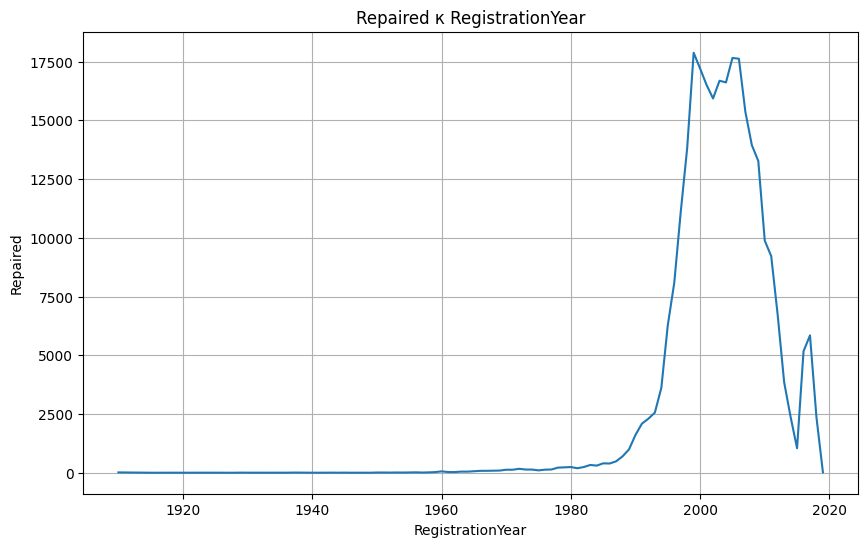

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(year_rep_ratio['RegistrationYear'], year_rep_ratio['Repaired'])
plt.title('Repaired к RegistrationYear')
plt.xlabel('RegistrationYear')
plt.ylabel('Repaired')
plt.grid()
plt.show()

Хочу проверить зависимость Repaired по годам, но имеется очень длинный хвост(есть экземпляры поэилых машин)

In [37]:
proc = df.loc[df['RegistrationYear']<=1985,'RegistrationYear'].count() / df.loc[df['RegistrationYear']>=1980,'RegistrationYear'].count()*100

In [38]:
print(f'Количество машин до 1985 года составляет {np.round(proc,2)}% от общего числа машин')

Количество машин до 1985 года составляет 1.75% от общего числа машин


в целом, это приемлемое количество. чтоыб удалить и привести наше распределение к нормальному

In [39]:
df = df[df['RegistrationYear']>=1985]

In [40]:
year_rep_ratio_1985 = df.groupby(['RegistrationYear'])['Repaired'].count().reset_index()

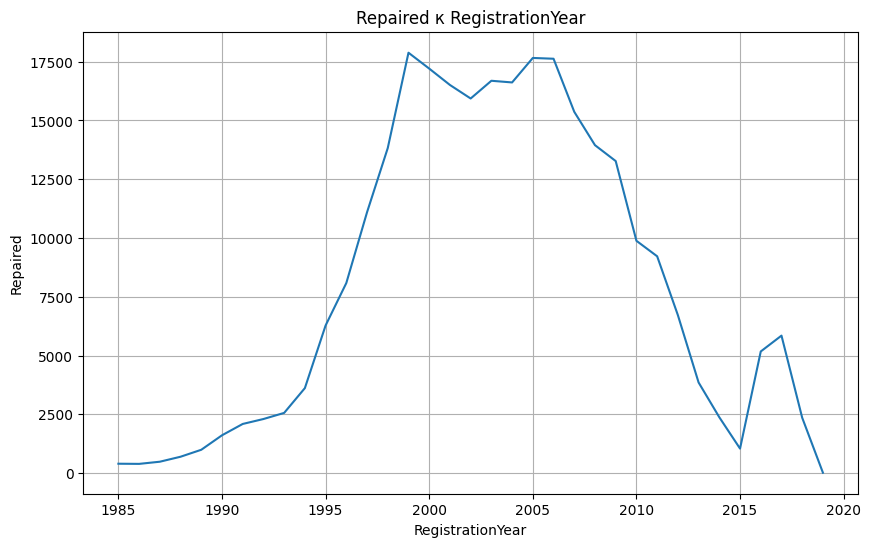

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(year_rep_ratio_1985['RegistrationYear'], year_rep_ratio_1985['Repaired'])
plt.title('Repaired к RegistrationYear')
plt.xlabel('RegistrationYear')
plt.ylabel('Repaired')
plt.grid()
plt.show()

С конца 1980-х до начала 2000-х наблюдается значительный рост количества починок, что, вероятно, связано с увеличением количества зарегистрированных автомобилей в этот период.

Максимальное количество починок приходится на начало 2000-х годов. После этого происходит постепенное снижение.

Количество починок резко уменьшается, начиная с 2010 года, что может быть связано с несколькими факторами, такими как снижение числа регистраций автомобилей или улучшение качества автомобилей, требующих меньше ремонтов.
Возможно, всплески после 2015 связаны с временными изменениями в объемах регистраций или активности на рынке + был подъем по покупательной способности по всей планете в целом.

Закрепим: Количество поломок зависит от пробега, чем больше пробег. тем больше поломок.
Количество поломок так же зависит от коробки:

Тут переведу столбец километр в категории(где 0 - это максимальный пробег, а 12 - это минимальынй пробег)


In [42]:
df_kil = df.copy(deep=True)
df_kil = reverse_ordinal_encode_kilometer(df_kil)
df_kil

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,0,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,1,5,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,1,8,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,0,6,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,3,7,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,0,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,10,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,1,3,petrol,smart,no,2016-03-05 00:00:00,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,0,3,gasoline,volkswagen,no,2016-03-19 00:00:00,2016-04-07 07:15:26


In [43]:
df[(df['Power']==0)]['Power'].count()
df[(df['Price']==0)]['Price'].count()

10295

In [44]:
df[(df['Price']==0)]['Price'].count()

10295

In [45]:
check_isna_dupl(df)

---ISNA COUNT---



DateCrawled              0
Price                    0
VehicleType          36617
RegistrationYear         0
Gearbox              18628
Power                    0
Model                18463
Kilometer                0
RegistrationMonth        0
FuelType             31665
Brand                    0
Repaired             69227
DateCreated              0
LastSeen                 0
dtype: int64

---DUPL COUNT---



5

---NUNIQUE---



DateCrawled          268092
Price                  3702
VehicleType               8
RegistrationYear         35
Gearbox                   2
Power                   706
Model                   248
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
LastSeen             177566
dtype: int64

Колонка: "DateCrawled" и её уникальные значения: ['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Колонка: "VehicleType" и её уникальные значения: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Колонка: "Gearbox" и её уникальные значения: ['manual' 'auto' nan]
Колонка: "Model" и её уникальные значения: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva' 'arosa'
 'other' 'c4' 'civic' 'punto' 'e_klasse' 'clio' 'kadett' 'kangoo' 'corsa'
 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8' 'jetta' 'fiesta'
 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort' 'forester' 'xc_reihe'
 'scenic' 'a4' 'ka' 'a1' 'insignia' 'transporter' 'combo' 'focus' 'tt'
 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe' 'sportage'
 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3' 'almera'
 'meg

Начнём заполнять пропуски в столбцах. Схема такая:

1. Заполнить VehicleType (на основе Brand,RegistrationYear)
2. Заполнить Model (на основе Brand, VehicleType, RegistrationYear)
3. Заполнить Gearbox (на основе VehicleType, Brand, Model)
4. Заполнить FuelType (на основе VehicleType, Brand, Model, Gearbox)
5. Заполнить нулевые значения в Power (на основе VehicleType, Model, FuelType)
6. Заполнить RegistrationMonth (заполнил модой по всем месяцам)
7. Заполнить Repaired (на основе всех других данных)


In [46]:
def fill_vehicle_type(df):

    df['VehicleType'] = df.groupby(['Brand', 'Model', 'RegistrationYear'])['VehicleType'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    

    df['VehicleType'] = df.groupby(['Brand', 'RegistrationYear'])['VehicleType'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    

    df['VehicleType'] = df.groupby(['Brand'])['VehicleType'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    
    df.replace(['None', None], np.nan, inplace=True)
    df.dropna(subset=['VehicleType'], inplace=True)
    
    return df

In [47]:
def fill_model(df):

    df['Model'] = df.groupby(['Brand', 'RegistrationYear'])['Model'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    

    df['Model'] = df.groupby(['Brand'])['Model'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

    df.replace(['None', None], np.nan, inplace=True)
    df.dropna(subset=['Model'], inplace=True)
    return df


In [48]:
def fill_gearbox(df):

    df['Gearbox'] = df.groupby(['Brand', 'Model', 'RegistrationYear'])['Gearbox'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    

    df['Gearbox'] = df.groupby(['Brand', 'Model'])['Gearbox'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    

    df['Gearbox'] = df.groupby(['Brand'])['Gearbox'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    

    df.replace(['None', None], np.nan, inplace=True)
    df.dropna(subset=['Gearbox'], inplace=True)
    
    return df

In [49]:
def fill_fuel_type(df):
    
    df['FuelType'] = df.groupby(['Brand', 'Model', 'RegistrationYear'])['FuelType'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    
    
    df['FuelType'] = df.groupby(['Brand', 'Model'])['FuelType'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    
  
    df['FuelType'] = df.groupby(['Brand'])['FuelType'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    

    df.replace(['None', None], np.nan, inplace=True)
    df.dropna(subset=['FuelType'], inplace=True)
    
    return df


In [50]:
def fill_power(df):

    df['Power'] = df.groupby(['Brand', 'Model', 'RegistrationYear'])['Power'].transform(lambda x: x.fillna(x.median()))
    

    df['Power'] = df.groupby(['RegistrationYear', 'Model'])['Power'].transform(lambda x: x.fillna(x.median()))
    

    df['Power'] = df.groupby(['RegistrationYear'])['Power'].transform(lambda x: x.fillna(x.median()))
    
    df.replace(['None', None], np.nan, inplace=True)
    df.dropna(subset=['Power'], inplace=True)
    return df


In [51]:
def fill_registration_month(df):
    for index, row in df[df['RegistrationMonth'].isna()].iterrows():
        df.at[index, 'RegistrationMonth'] = random.randint(1, 12)
    for index, row in df[df['RegistrationMonth'] == 0].iterrows():
        df.at[index, 'RegistrationMonth'] = random.randint(1, 12)
    return df

In [52]:
def fill_repaired(df):

    repaired_map = df.groupby(['Gearbox', 'RegistrationYear', 'Brand', 'Model', 'Power'])['Repaired'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    

    for index, row in df[df['Repaired'].isna()].iterrows():
        gearbox = row['Gearbox']
        reg_year = row['RegistrationYear']
        brand = row['Brand']
        model = row['Model']
        power = row['Power']
        
        if (gearbox, reg_year, brand, model, power) in repaired_map.index:
            df.at[index, 'Repaired'] = repaired_map[(gearbox, reg_year, brand, model, power)]

    repaired_map = df.groupby(['Gearbox', 'RegistrationYear', 'Brand'])['Repaired'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    
    for index, row in df[df['Repaired'].isna()].iterrows():
        gearbox = row['Gearbox']
        reg_year = row['RegistrationYear']
        brand = row['Brand']
        
        if (gearbox, reg_year, brand) in repaired_map.index:
            df.at[index, 'Repaired'] = repaired_map[(gearbox, reg_year, brand)]

    repaired_map = df.groupby(['Gearbox', 'RegistrationYear'])['Repaired'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    
    for index, row in df[df['Repaired'].isna()].iterrows():
        gearbox = row['Gearbox']
        reg_year = row['RegistrationYear']
        
        if (gearbox, reg_year) in repaired_map.index:
            df.at[index, 'Repaired'] = repaired_map[(gearbox, reg_year)]

    df.replace(['None', None], np.nan, inplace=True)
    df.dropna(subset=['Repaired'], inplace=True)
    
    return df


In [53]:
def fill_price(df):

    df['Price'] = df.groupby(['Kilometer','Power','Brand', 'Model', 'RegistrationYear'])['Price'].transform(lambda x: x.fillna(x.median()))

    df['Price'] = df.groupby(['Kilometer','Power','Brand', 'RegistrationYear'])['Price'].transform(lambda x: x.fillna(x.median()))

    df['Price'] = df.groupby(['Kilometer','Power','RegistrationYear'])['Price'].transform(lambda x: x.fillna(x.median()))
    df['Price'] = df.groupby(['Kilometer','RegistrationYear'])['Price'].transform(lambda x: x.fillna(x.median()))
    df['Price'] = df.groupby(['RegistrationYear'])['Price'].transform(lambda x: x.fillna(x.median()))

    df.dropna(subset=['Price'], inplace=True)
    
    return df

In [54]:
def replace_zeros(df):
    # Шаг 1: Заменяем нули в Power медианой для каждой комбинации Brand, Model и RegistrationYear
    df['Power'] = df.groupby(['Brand', 'Model', 'RegistrationYear'])['Power'].transform(lambda x: x.replace(0, x.median()))
    
    # Шаг 2: Заменяем нули общей медианой для Power
    power_median = df['Power'].median()
    df['Power'] = df['Power'].replace(0, power_median)
    
    # Шаг 3: Заменяем нули в Price медианой для каждой комбинации Brand, Model и RegistrationYear
    df['Price'] = df.groupby(['Brand', 'Model', 'RegistrationYear'])['Price'].transform(lambda x: x.replace(0, x.median()))
    
    # Шаг 4: Заменяем нули общей медианой для Price
    price_median = df['Price'].median()
    df['Price'] = df['Price'].replace(0, price_median)
    
    return df

In [55]:
def drop_dates(df):
    date_columns = ['DateCrawled','DateCreated','LastSeen']
    df = df.drop(columns=date_columns)
    return df

In [56]:
def trim_by_three_sigma(df):

    # Вычисляем среднее и стандартное отклонение
    mean = df['Power'].mean()
    std_dev = df['Power'].std()
    
    # Определяем границы по правилу трех сигм
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    
    # Фильтруем значения внутри диапазона
    df_filtered = df[(df['Power'] >= lower_bound) & (df['Power'] <= upper_bound)]
    
    return df_filtered

In [57]:
def remove_duplicates(df):
    df = df.drop_duplicates()
    return df

In [58]:
def remove_cols(df):
    df = df.drop(columns=['PostalCode','NumberOfPictures'])
    return df

In [59]:
def rep_regyear(df):
    df = df[(df['RegistrationYear']>1985)&(df['RegistrationYear']<2024)]
    return df

In [60]:
def cat_to_str(df):
    obj_columns = df.select_dtypes(include=['object']).columns
    df[obj_columns] = df[obj_columns].astype(str)
    return df

In [61]:
def kilo_to_cat(df):
    df['Kilometer'] = df['Kilometer'].astype(str)
    return df

In [62]:
def fill_missing_data(df):
    df_copy = df.copy(deep=True)
    df_copy = rep_regyear(df_copy)
    df_copy = remove_cols(df_copy)
    df_copy = remove_duplicates(df_copy)
    df_copy = drop_dates(df_copy)
    df_copy = fill_vehicle_type(df_copy)
    df_copy = fill_model(df_copy)
    df_copy = fill_gearbox(df_copy)
    df_copy = fill_fuel_type(df_copy)
    df_copy = fill_power(df_copy)
    df_copy = fill_registration_month(df_copy)
    df_copy = fill_repaired(df_copy)
    df_copy = fill_price(df_copy)
    df_copy = replace_zeros(df_copy)
    df_copy = cat_to_str(df_copy)
    df_copy = kilo_to_cat(df_copy) 
    df_copy = trim_by_three_sigma(df_copy)
    df_copy = remove_duplicates(df_copy)
    return df_copy

In [63]:
df_filled_3 = fill_missing_data(data)

In [64]:
data_pipe = df_filled_3.copy(deep=True)

In [65]:
data_pipe.to_csv('read.csv')

In [66]:
check_isna_dupl(df_filled_3)

---ISNA COUNT---



Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

---DUPL COUNT---



0

---NUNIQUE---



Price                3883
VehicleType             8
RegistrationYear       34
Gearbox                 2
Power                 566
Model                 248
Kilometer              13
RegistrationMonth      12
FuelType                7
Brand                  39
Repaired                2
dtype: int64

Колонка: "VehicleType" и её уникальные значения: ['sedan' 'wagon' 'suv' 'small' 'convertible' 'bus' 'coupe' 'other']
Колонка: "Gearbox" и её уникальные значения: ['manual' 'auto']
Колонка: "Model" и её уникальные значения: ['golf' 'a4' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva' 'arosa'
 'other' 'c4' 'civic' 'punto' 'e_klasse' 'clio' 'kadett' 'kangoo' 'corsa'
 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8' 'jetta' 'fiesta'
 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort' 'forester' 'xc_reihe'
 'scenic' 'ka' 'a1' 'insignia' 'transporter' 'combo' 'focus' 'tt' 'a6'
 'jazz' 'omega' 'slk' '7er' '80' '147' 'z_reihe' 'sportage' 'sorento'
 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3' 'almera' 'megane'
 'lupo' 'r19' 'zafira' 'mondeo' 'cordoba' 'colt' 'impreza' 'vectra'
 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan' '6_reihe' 'panda' 'up'
 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii' 'rx_reihe'

In [67]:
df_filled_3

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480.0,sedan,1993,manual,75.0,golf,150000,2,petrol,volkswagen,no
1,18300.0,wagon,2011,manual,190.0,a4,125000,5,gasoline,audi,yes
2,9800.0,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no
3,1500.0,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600.0,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200.0,sedan,2004,manual,225.0,leon,150000,5,petrol,seat,yes
354364,2499.0,small,2005,manual,95.0,colt,150000,7,petrol,mitsubishi,yes
354366,1199.0,convertible,2000,auto,101.0,fortwo,125000,3,petrol,smart,no
354367,9200.0,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,no


После заполнения пропусков получается 14к дубликатов, в любом случае, мы приходим к тому, что мы дропаем эти дубликаты, если не можешь качественно и корректно заместить их пропуски. 14/354 - это примерно 4% данных, не так больно, но всё же.

Text(0, 0.5, 'Количество')

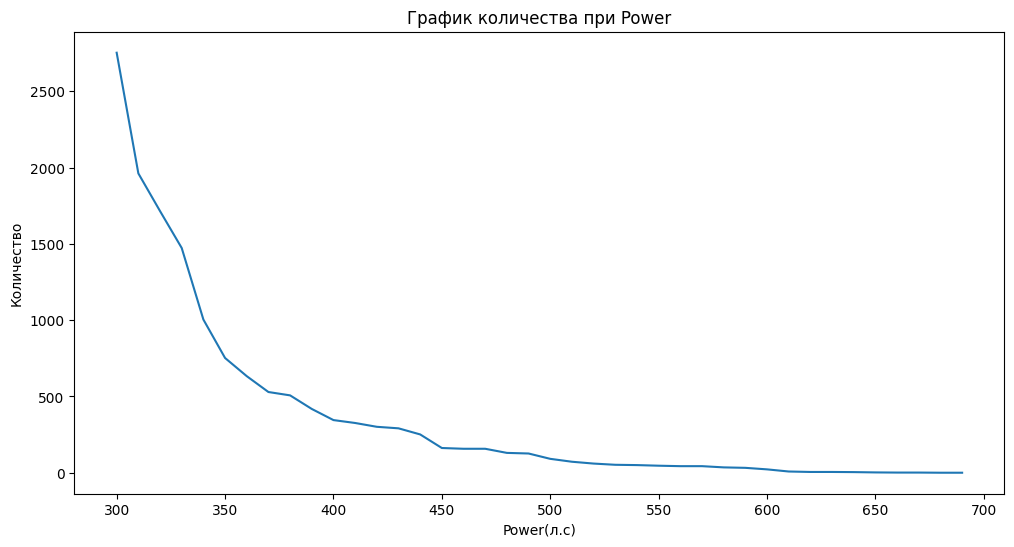

In [68]:
power_list=[]
rang = range(300,700,10)
for i in rang:
    power_list.append(df_filled_3[(df_filled_3['Power']>i)]['Power'].count())
plt.figure(figsize=(12,6))
plt.plot(rang, power_list)
plt.title('График количества при Power')
plt.xlabel('Power(л.с)')
plt.ylabel('Количество')

По графику, аналогично методу локтя, я бы сказал:

 что количество машин начинает монотонно убывать от 450 л.с(595 наблюдений), незначительно падая. 
Конечно, идеално было бы поступить по правилу трех сигм, но тогда данные будут максимально постные(). Так что же делать?
Конкретн ов моем случае я предвижу, что выбросы(мега дорогие или мегадешевые машины) - это не есть гуд, почему? Будет смещение предсказаний, таким образом более дорогие перетянут одеяло, и ошибка модели будет больше маленьких значений. Вывход есть - делать нескольк омоделей для каждог осегмента отдельно. Предвидя это - я поступлю юезжалостно. но в пределах нормальной практики, типа, я не знаю))) Отсавлю данные в пределах 3 сигм(99.7%), и будем работать с ними.


Есть дубли, дропаем

In [69]:
def find_duplicate_models(df):
    # Группируем данные по модели и бренду
    model_brand_counts = df.groupby(['Model', 'Brand']).size().reset_index(name='count')
    
    # Находим модели, которые встречаются у нескольких брендов
    duplicate_models = model_brand_counts.groupby('Model')['Brand'].nunique()
    duplicate_models = duplicate_models[duplicate_models > 1]  # Оставляем только те модели, которые встречаются у более чем одного бренда
    
    return duplicate_models

In [70]:
duplicate_models = find_duplicate_models(df_filled_3)
duplicate_models

Model
1_reihe        2
3_reihe        2
5_reihe        2
defender       2
discovery      2
freelander     2
grand          3
matiz          2
other         39
Name: Brand, dtype: int64

На всякий случай,проверил коллизию моделей у разных брендов, тут всё ок

In [71]:
def plot_numeric_columns(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Построение гистограмм для всех числовых столбцов
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Распределение {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.show()
        plt.figure(figsize=(10, 6))
        plt.boxplot(df[col])
        plt.xlabel(col)
        plt.ylabel('Значения')
        plt.show()

In [72]:
def plot_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Построение графиков для всех категориальных столбцов
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        # Столбчатая диаграмма
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Распределение {col}')
        plt.xlabel('Количество')
        plt.ylabel(col)
        plt.show()
        # Круговая диаграмма
        plt.figure(figsize=(8, 8))
        df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3')
        plt.title(f'Распределение {col} (круговая диаграмма)')
        plt.ylabel('')
        plt.show()


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


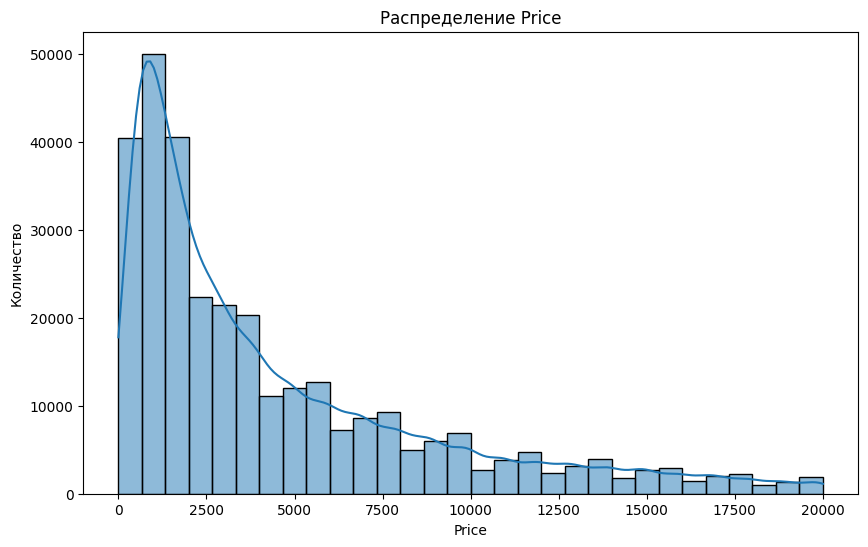

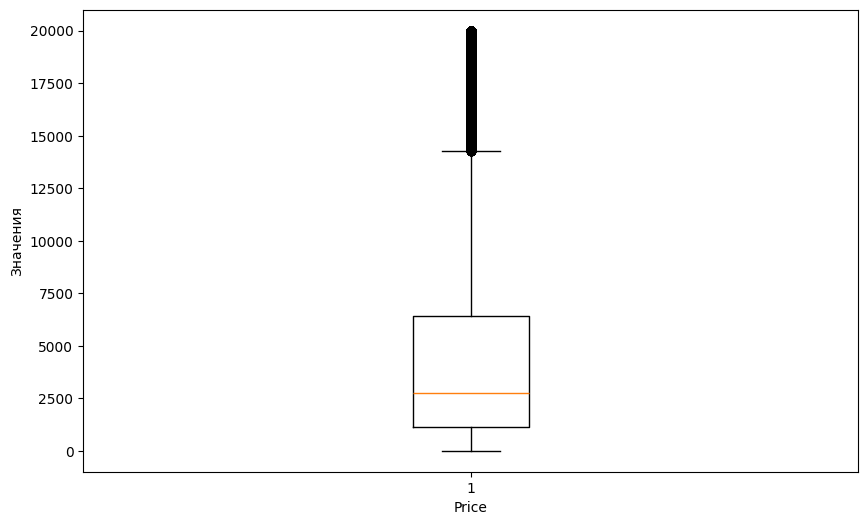

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


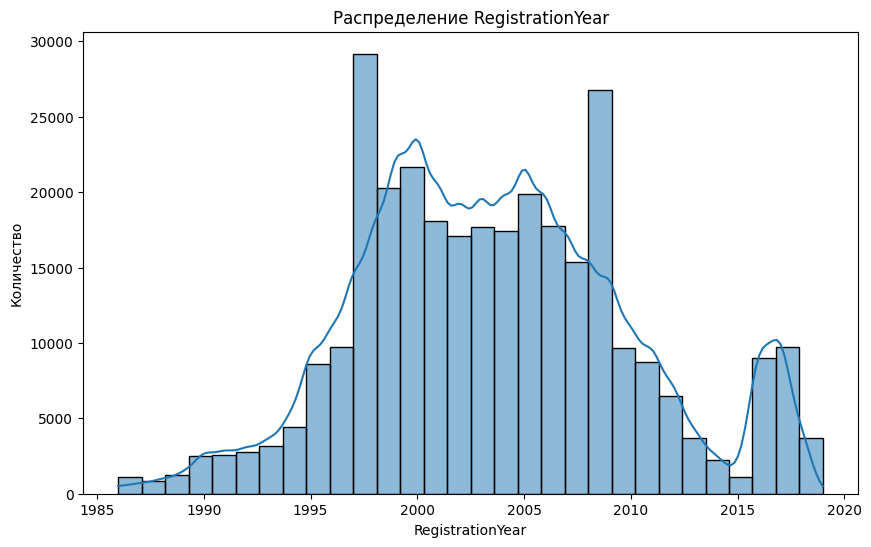

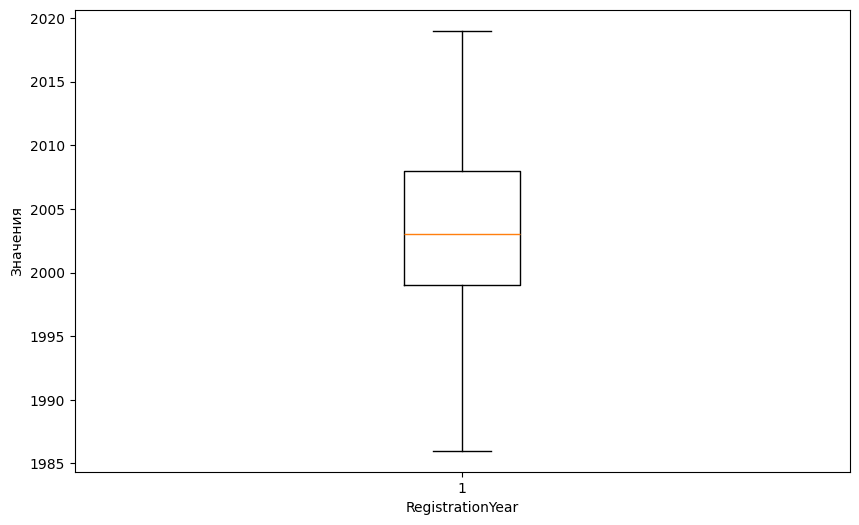

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


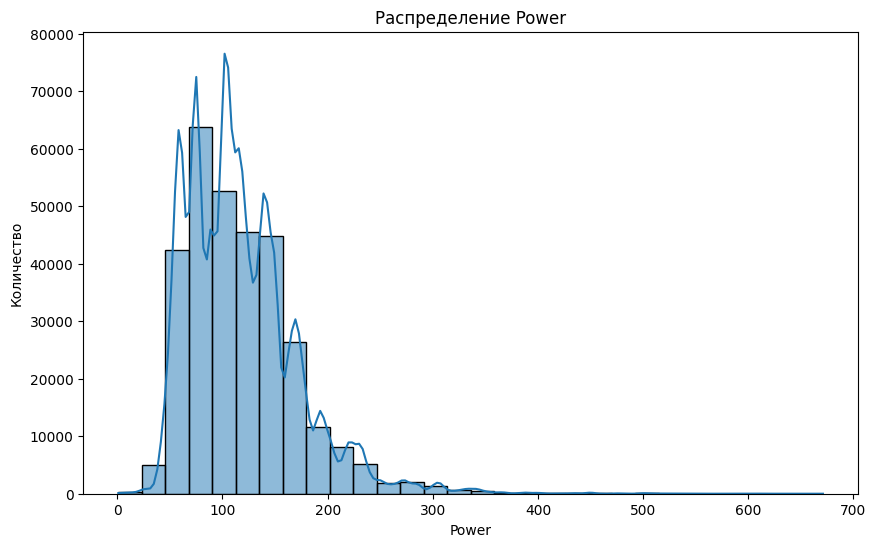

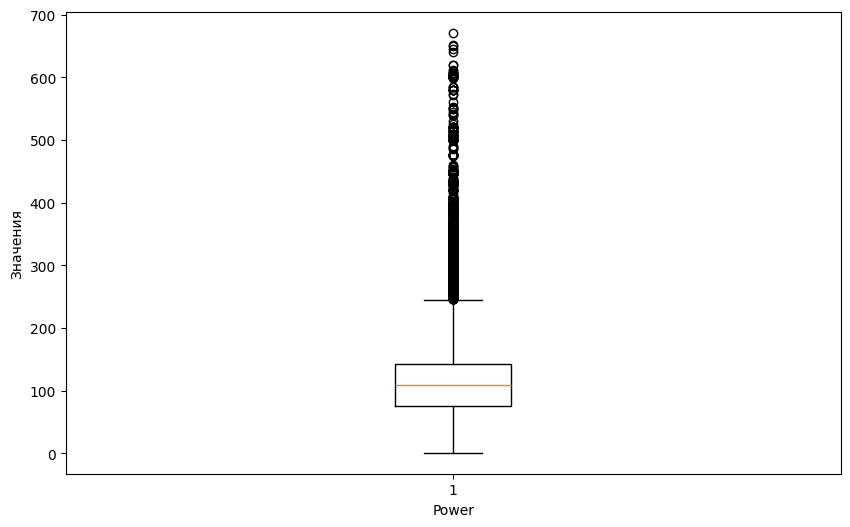

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


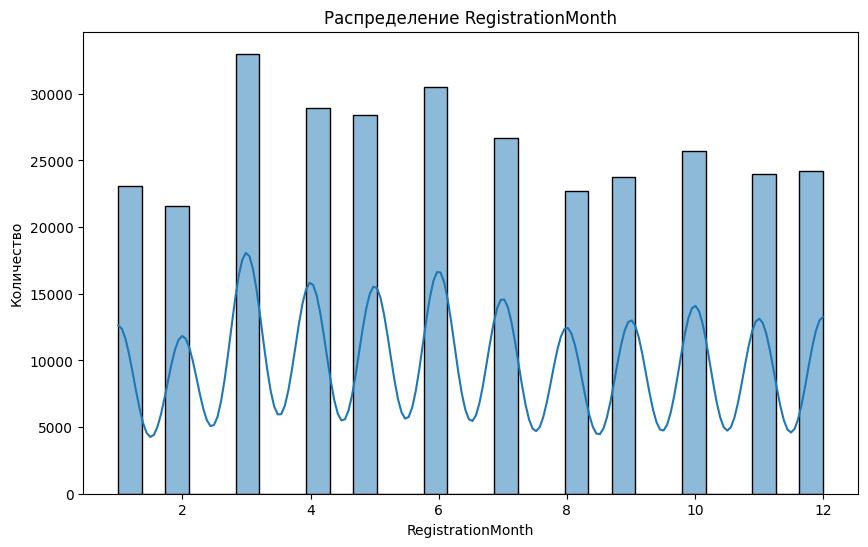

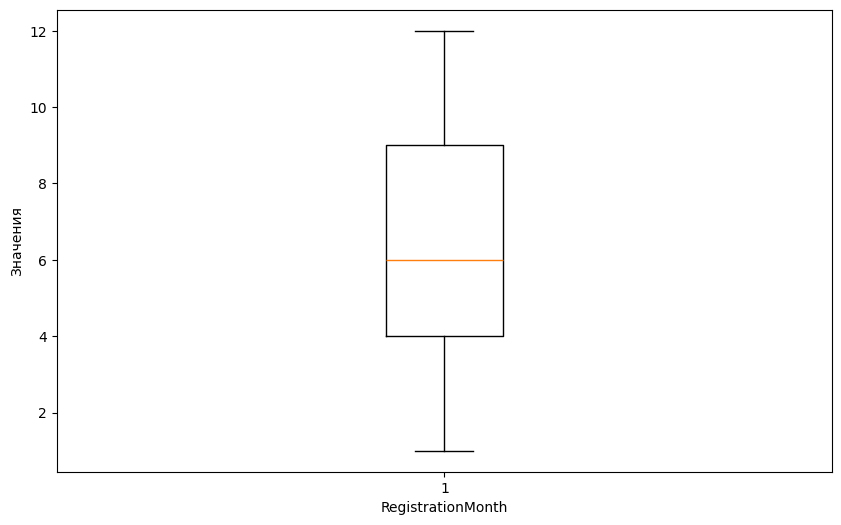

In [73]:
# Построение графиков для числовых столбцов
plot_numeric_columns(df_filled_3)

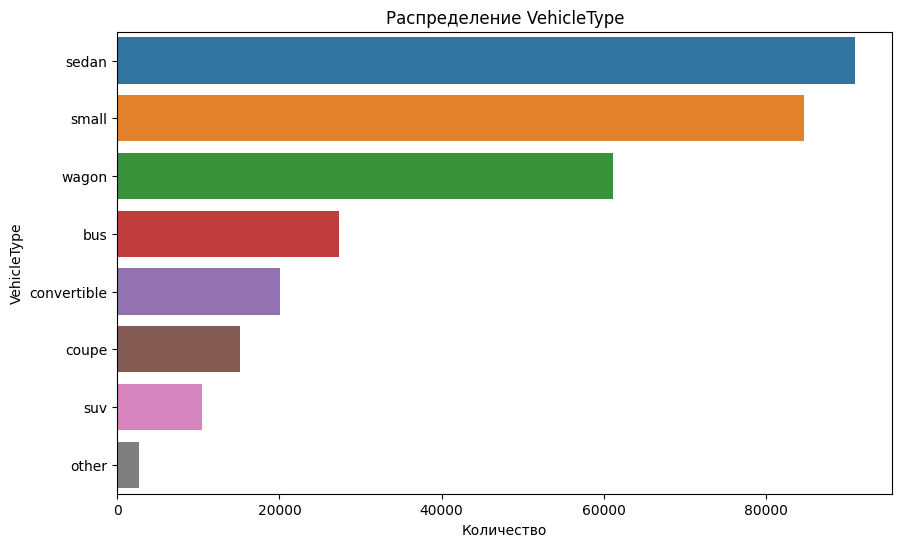

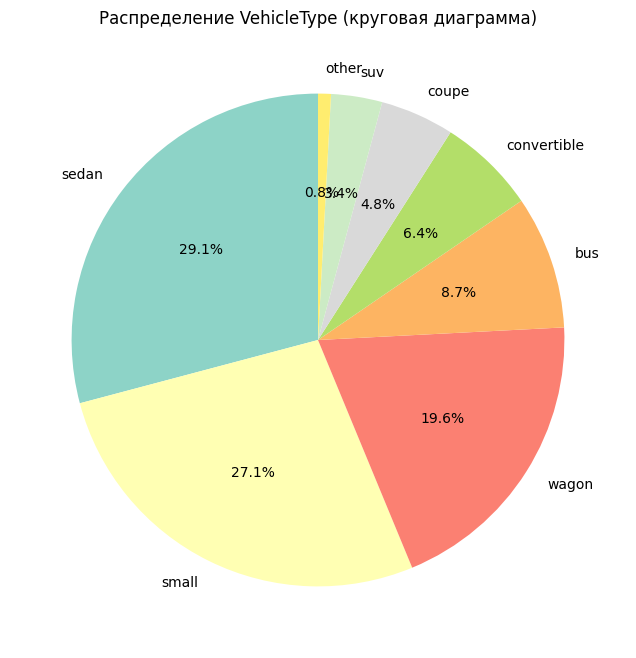

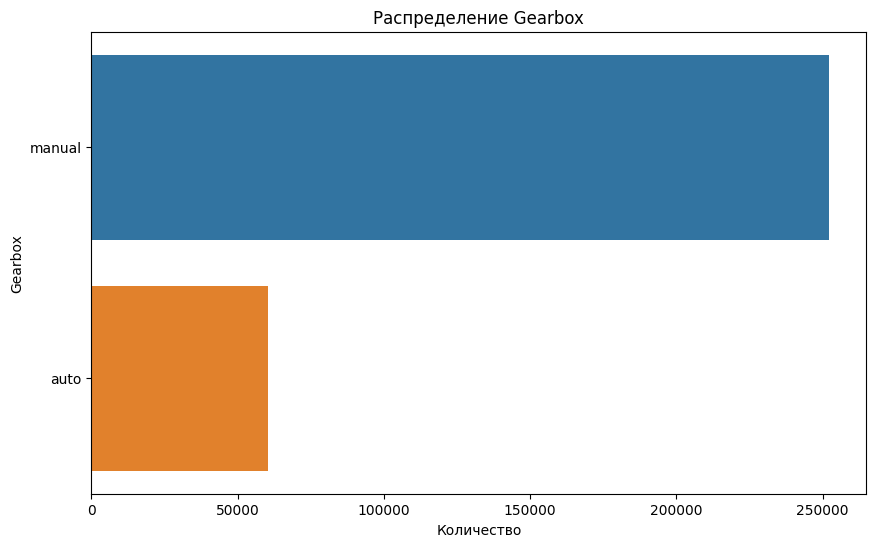

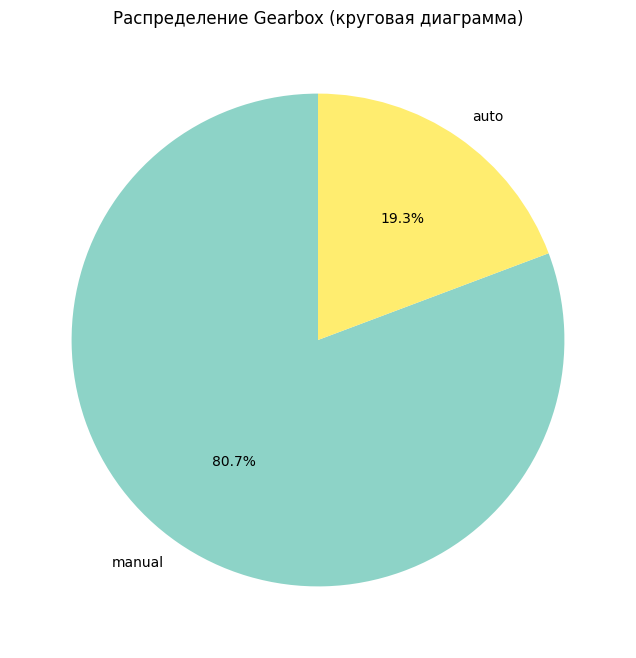

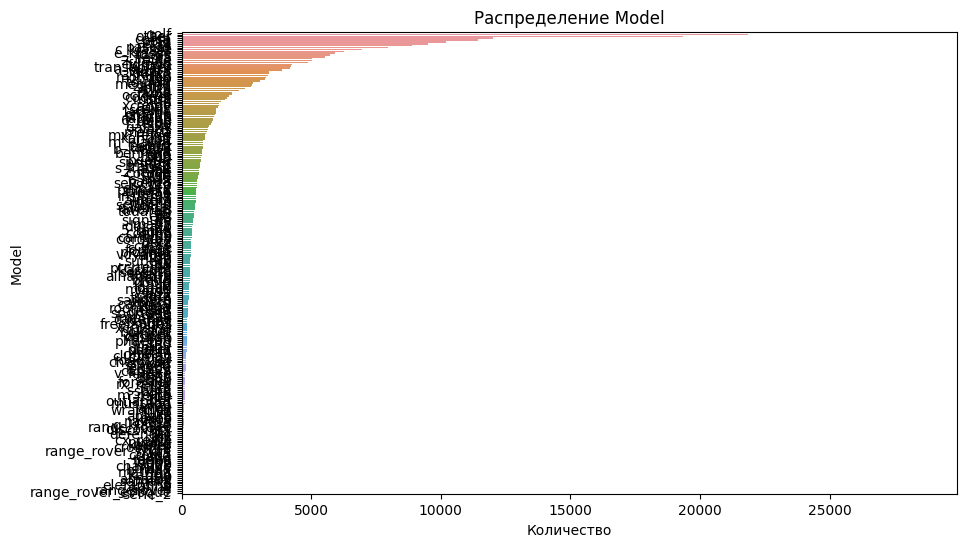

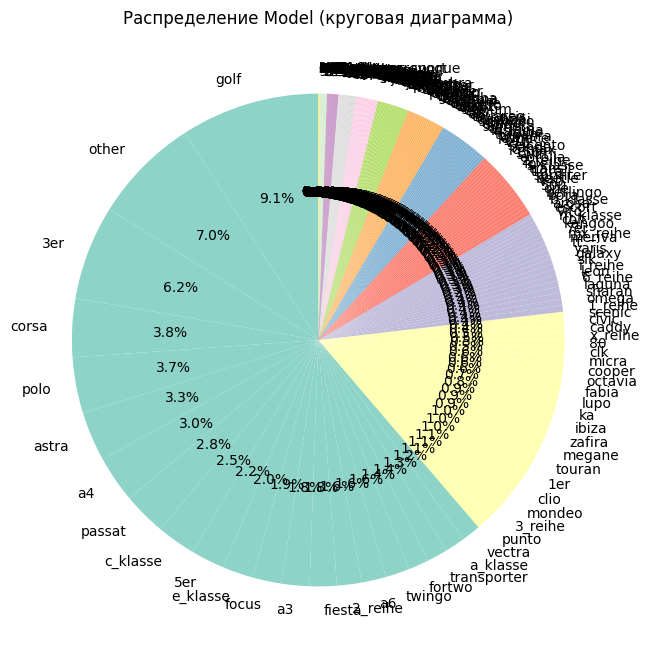

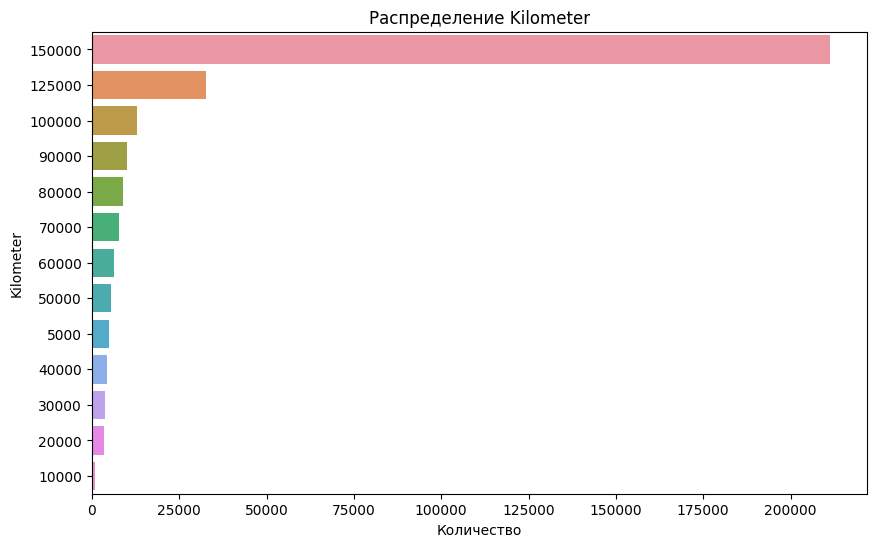

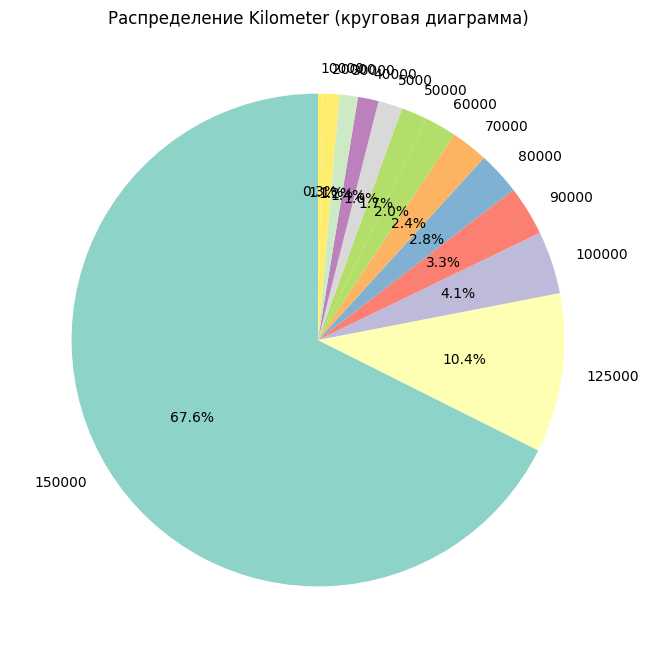

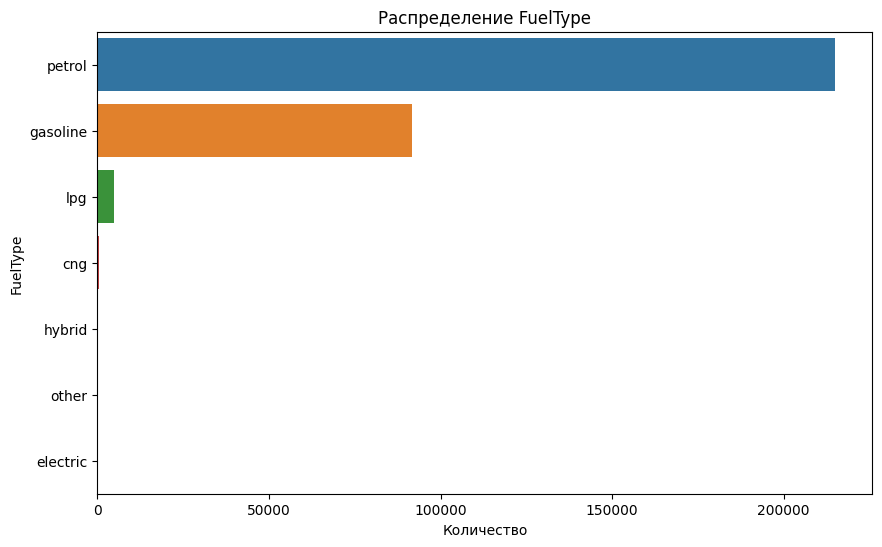

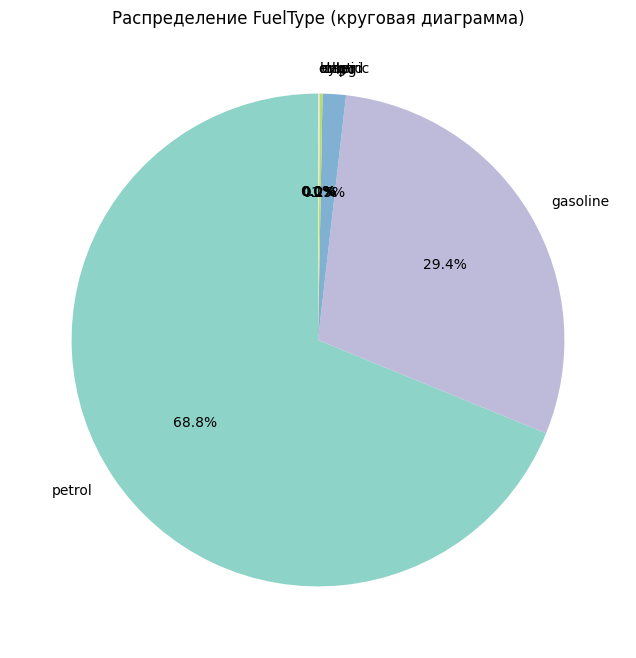

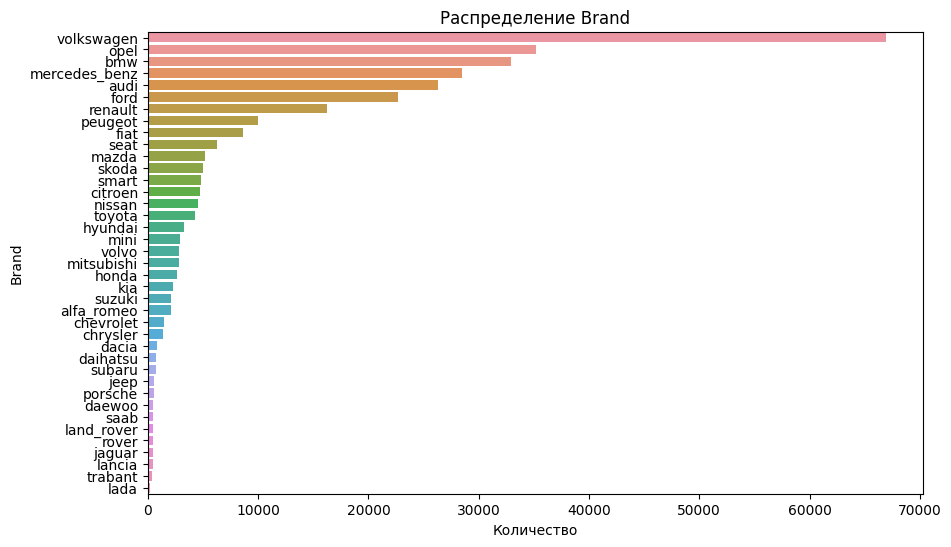

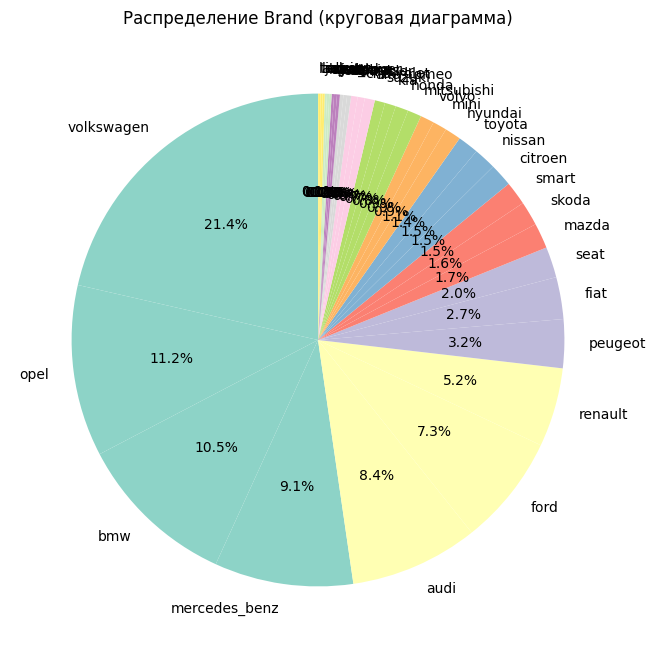

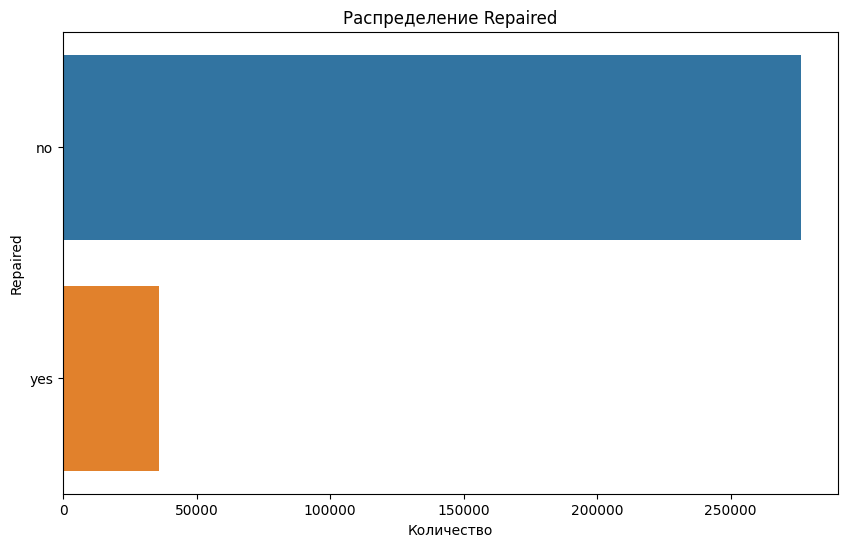

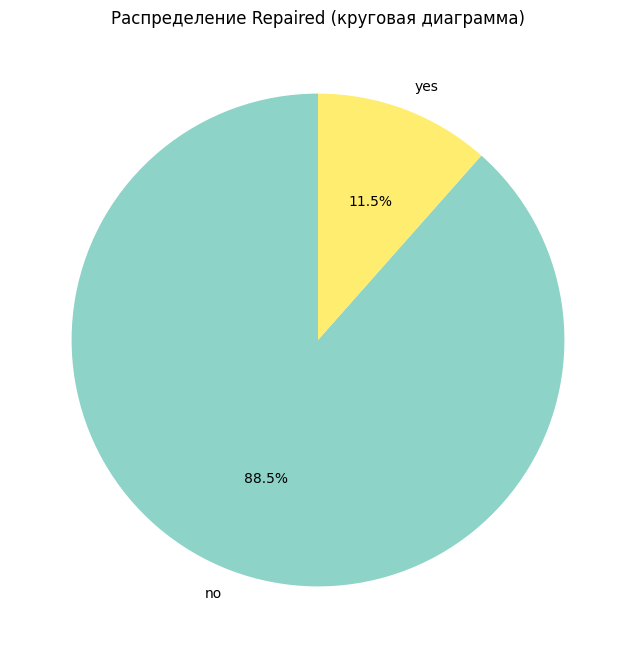

In [74]:
# Построение графиков для категориальных столбцов
plot_categorical_columns(df_filled_3)

In [75]:
# top_10_frequent_values(df_filled_3, df_filled_3.columns)

**Отчет по графикам и статистикам.**

1. Распределение Gearbox (коробка передач)
Преобладает механическая коробка передач — около 80.9% автомобилей.
Автомобили с автоматической коробкой передач составляют 19.1%.

*На рынке представлено значительно больше автомобилей с механической трансмиссией, что может свидетельствовать о популярности более старых или бюджетных моделей.*

2. Распределение VehicleType (тип кузова)
Наиболее популярные типы кузова:
- Седан — 29.3%
- Малолитражка (small) — 27.3%
- Универсал (wagon) — 19.5%
- Реже встречаются:
- Купе — 4.8%
- Внедорожники (SUV) — 3.3%
- Прочие типы кузова — 0.8%

*Основной спрос приходится на седаны и малолитражки, которые подходят для повседневного использования. Внедорожники и другие типы кузова представлены в меньших количествах.*

3. Распределение RegistrationMonth (месяц регистрации)
- Сезонные пики могут отражать реальные тренды на регистрацию автомобилей в марте и апреле.

4. Распределение Kilometer (пробег)
68% автомобилей имеют пробег свыше 150 000 км.

*Небольшая часть автомобилей имеет пробег менее 20 000 км, что может свидетельствовать о продаже новых или почти новых автомобилей.*


5. Распределение Power (мощность двигателя)
Большинство автомобилей имеют мощность от 60 до 150 л.с.
Есть значения, где мощность превышает 300 л.с., что скорее всего относится к редким высокопроизводительным моделям.

*Мощность большинства автомобилей сосредоточена в диапазоне 60-150 л.с., что является нормой для большинства легковых автомобилей.*

6. Распределение RegistrationYear (год регистрации)
Автомобили преимущественно зарегистрированы с 1995 по 2010 год.
Пик регистраций приходится на 2000 год, возможно, это связано с популярностью определённых моделей в этот период.

*Большинство автомобилей на рынке — это подержанные машины возрастом более 10 лет.*

7. Распределение Price (цена)
Основная часть автомобилей имеет цену до 5000 евро.
Пик приходится на диапазон 500-2500 евро.
Цены выше 10 000 евро встречаются редко.

*Это типично для рынка подержанных автомобилей, где большинство автомобилей продаются по сравнительно низким ценам.*

**Как поступить с дата столбцами?**

Перевел их из object в datetime и нормализовал, но в будущем буду строить отдельыне пайплайны. Катбуст поддерживает датые - оставлютам предобработку, в ругих пайплайнах я просто дропну даты, попытался придумать фичу по типу "активность" (дата захода - дата регистрации), но не смог придумать, как бы отнормировать это, понимая, что могу быть МЕГАпассивные продавцы(зарегистрирвоался в 2016, зашел в 2019 за день до выгрузки. условно, соотв., активность такого человека будет номинальная, но будет - нихт гуд). Так что просто дропну и буду надеяться на катбуст!)

# Анализ признаков

In [76]:
ph_matr = df_filled_3.phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'RegistrationMonth']


In [77]:
ph_matr.to_csv('ph_matr.csv')

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


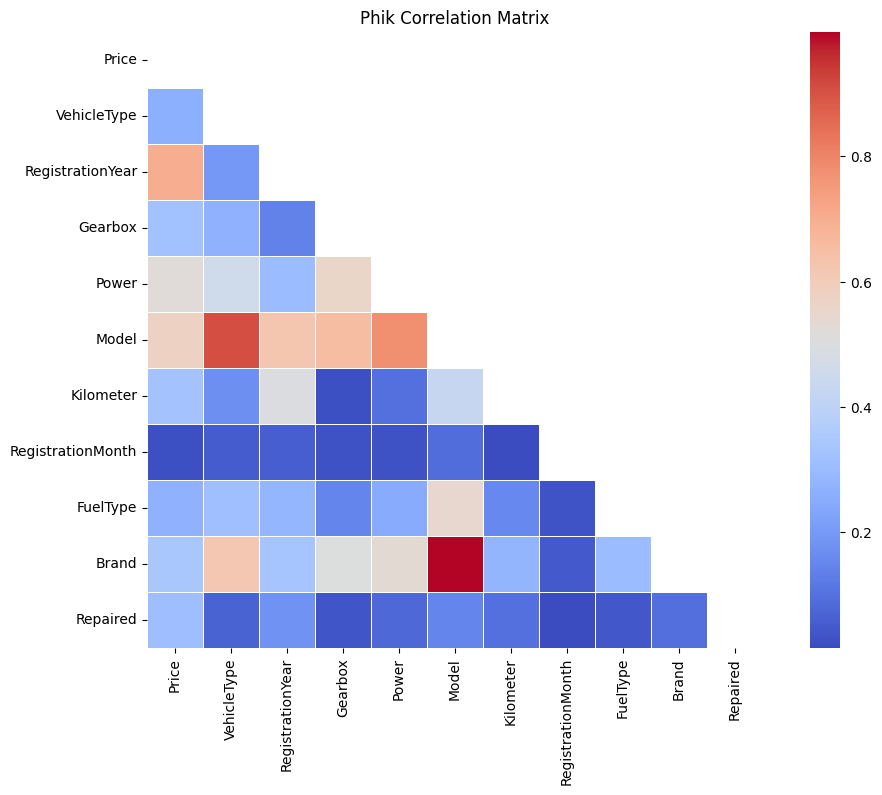

In [78]:
mask = np.triu(np.ones_like(ph_matr, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(ph_matr, mask=mask, annot=True, cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Phik Correlation Matrix')
plt.show()

1. Зависимость между Price и другими признаками:
- RegistrationYear (0.699): Сильная положительная корреляция. Чем новее автомобиль, тем выше его цена. Это типичная зависимость, так как новые автомобили обычно дороже подержанных.
- Power (0.524): Средняя положительная корреляция. Более мощные автомобили имеют более высокую цену, что также объяснимо, так как мощность часто связана с более дорогими комплектующими и эксплуатационными характеристиками.
- Model (0.580): Модель автомобиля имеет заметное влияние на его цену. Некоторые модели более престижны или высоко оценены на рынке, что повышает их стоимость.
- VehicleType (0.268): Слабая корреляция с типом кузова. Автомобили с разными типами кузова имеют различную стоимость, но это влияние не так значительно, как у других признаков.
- Gearbox (0.329): Есть средняя корреляция между ценой и типом коробки передач, причём автомобили с автоматической трансмиссией часто дороже.
- Kilometer (0.311): Слабая корреляция с пробегом. Влияние пробега на цену есть, но оно относительно небольшое.
- FuelType (0.276): Слабая корреляция с типом топлива. Автомобили с бензиновыми двигателями часто дешевле, чем гибридные или электрические автомобили, что может объяснять эту связь.
- Brand (0.342): Корреляция с брендом автомобиля показывает, что бренд имеет влияние на цену — некоторые марки более престижны и стоят дороже.
- Repaired (0.301): Слабая положительная корреляция указывает на то, что автомобили с историей ремонта могут иметь несколько сниженную цену.
2. Зависимость между VehicleType и другими признаками:
- Model (0.911): Очень сильная корреляция между типом кузова и моделью автомобиля. Это ожидаемо, так как определённые модели выпускаются с конкретными типами кузова.
- Brand (0.617): Средняя корреляция с маркой автомобиля, так как многие производители специализируются на выпуске определённых типов кузовов.
- Power (0.463): Средняя корреляция с мощностью автомобиля. Определённые типы кузова (например, внедорожники) часто обладают более мощными двигателями.
3. Зависимость между RegistrationYear и другими признаками:
- Price (0.699): Сильная положительная корреляция. Как уже было сказано, чем новее автомобиль, тем выше его стоимость.
- Model (0.628): Сильная корреляция, что объясняется тем, что определённые модели чаще производятся в конкретные годы.
- Kilometer (0.474): Сравнительно сильная корреляция с пробегом автомобиля. Чем старше автомобиль, тем больше у него километраж.
- Power (0.311): Средняя корреляция с мощностью. В более поздних годах регистрации автомобили часто имеют более мощные двигатели.
4. Зависимость между Gearbox и другими признаками:
- Power (0.562): Сильная положительная корреляция с мощностью. Более мощные автомобили чаще оснащаются автоматическими коробками передач.
- Model (0.658): Сильная корреляция. Определённые модели автомобилей чаще оснащены тем или иным типом коробки передач.
- VehicleType (0.274): Средняя корреляция с типом кузова. Например, внедорожники и крупные автомобили чаще оснащаются автоматическими коробками передач.
5. Зависимость между Power и другими признаками:
- Model (0.779): Сильная корреляция с моделью автомобиля. Мощность сильно зависит от конкретной модели, так как разные модели производятся с определённым диапазоном мощности.
- Brand (0.532): Средняя корреляция. Бренды автомобилей часто предлагают модели с определённой мощностью.
- VehicleType (0.463): Средняя корреляция с типом кузова. Определённые типы кузова, такие как внедорожники, часто обладают более мощными двигателями.
6. Зависимость между Model и другими признаками:
- VehicleType (0.911): Очень сильная корреляция, что подтверждает зависимость модели от типа кузова.
- Power (0.779): Сильная корреляция с мощностью автомобиля. Определённые модели автомобилей производятся с конкретной мощностью.
- Gearbox (0.658): Сильная корреляция. Разные модели имеют разные типы коробки передач.
7. Зависимость между Kilometer и другими признаками:
- RegistrationYear (0.474): Сильная корреляция с годом регистрации. Чем старше автомобиль, тем больше у него километраж.
- Price (0.311): Слабая отрицательная корреляция с ценой автомобиля. Пробег влияет на цену, но не является ключевым фактором.
8. Зависимость между FuelType и другими признаками:
- VehicleType (0.316): Средняя корреляция. Определённые типы кузова могут использовать определённые виды топлива (например, внедорожники чаще используют дизельное топливо).
- Power (0.255): Слабая корреляция с мощностью автомобиля. Определённые типы топлива связаны с определённой мощностью двигателя.
9. Зависимость между Brand и другими признаками:
- Model (0.999): Почти полная корреляция с моделью автомобиля, что ожидаемо, так как модель всегда связана с брендом.
- VehicleType (0.617): Средняя корреляция. Определённые бренды специализируются на выпуске определённых типов кузова.
- Power (0.532): Средняя корреляция с мощностью автомобиля, так как бренды часто предлагают модели с определённой мощностью.
10. Зависимость между Repaired и другими признаками:
- Price (0.301): Слабая корреляция. История ремонта может влиять на цену автомобиля, но не является решающим фактором.

Общие выводы:
- Мультиколлинеарность между Model, Brand, и VehicleType:
- Значимые признаки для предсказания цены: RegistrationYear, Power, Model, и Brand
- Слабая корреляция с пробегом и типом топлива

In [79]:
def calculate_vif(df):
    """
    Функция для расчета коэффициентов инфляции дисперсии (VIF) для DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame с признаками.

    Returns:
    pd.DataFrame: DataFrame с признаками и их соответствующими VIF значениями.
    """
    # Добавляем константу для расчета VIF
    X = sm.add_constant(df)
    
    # Вычисляем VIF для каждого признака
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Удаляем строку с константой
    vif_data = vif_data[vif_data["feature"] != "const"]
    
    return vif_data

In [80]:
vif_df = calculate_vif(df_filled_3.select_dtypes(include=['int64', 'float64']))
print(vif_df)

             feature       VIF
1              Price  1.797068
2   RegistrationYear  1.339347
3              Power  1.408471
4  RegistrationMonth  1.000367


Числовые признаки меньше 5 и больше 1 -> оставляем

scatter не буду строить

# Пайплайны

Построю отдельные пайплайны для моделей:
- catboost
- lightgbm
- randomforest

**Catboost**

In [81]:
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired']
numeric_features = ['Power','RegistrationYear','RegistrationMonth']

In [82]:
# Разделение на тренировочные и тестовые данные
X = data_pipe.drop(columns='Price')
y = data_pipe['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]

In [83]:
class DataFrameTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, transformer):
        self.transformer = transformer
        
    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self
    
    def transform(self, X):
        X_transformed = self.transformer.transform(X)
        feature_names = self.get_feature_names_out()
        return pd.DataFrame(X_transformed, columns=feature_names, index=X.index)
    
    def get_feature_names_out(self, input_features=None):
        return self.transformer.get_feature_names_out(input_features)

In [84]:
numeric_transformer_cb = Pipeline(steps=[
    ('scaler', 'passthrough')
])

preprocessor_cb = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_cb, numeric_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

df_preprocessor = DataFrameTransformer(preprocessor_cb)


class CatBoostRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, cat_features=None, **params):
        self.cat_features = cat_features
        self.params = params
        
    def fit(self, X, y):
        self.model = CatBoostRegressor(cat_features=self.cat_features, **self.params)
        self.model.fit(X, y, verbose=False)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def get_params(self, deep=True):
        return {'cat_features': self.cat_features, **self.params}
    
    def set_params(self, **params):
        self.cat_features = params.pop('cat_features', self.cat_features)
        self.params.update(params)
        return self

In [85]:
pipeline_cb = Pipeline(steps=[
    ('preprocessor', df_preprocessor),
    ('model', CatBoostRegressorWrapper(cat_features=categorical_features, task_type='GPU', devices='0'))
])

In [86]:
param_grid_cb = {
    'preprocessor__transformer__num__scaler': [StandardScaler(), MinMaxScaler()],
    'model__depth': [4, 6, 8, 10],
    'model__learning_rate': np.logspace(-3, -1, 10),
    'model__iterations': [200, 500, 700]
}

In [87]:
random_search_cb = RandomizedSearchCV(
    pipeline_cb,
    param_distributions=param_grid_cb,
    n_iter=10,
    cv=3,
    random_state=42,
    verbose=3,
    n_jobs=1,
    scoring=rmse_scorer
)

In [88]:
random_search_cb.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END model__depth=4, model__iterations=500, model__learning_rate=0.0027825594022071257, preprocessor__transformer__num__scaler=StandardScaler();, score=-2612.129 total time=  12.3s
[CV 2/3] END model__depth=4, model__iterations=500, model__learning_rate=0.0027825594022071257, preprocessor__transformer__num__scaler=StandardScaler();, score=-2606.798 total time=  13.0s
[CV 3/3] END model__depth=4, model__iterations=500, model__learning_rate=0.0027825594022071257, preprocessor__transformer__num__scaler=StandardScaler();, score=-2592.658 total time=  12.9s
[CV 1/3] END model__depth=4, model__iterations=200, model__learning_rate=0.004641588833612777, preprocessor__transformer__num__scaler=StandardScaler();, score=-2962.184 total time=   5.7s
[CV 2/3] END model__depth=4, model__iterations=200, model__learning_rate=0.004641588833612777, preprocessor__transformer__num__scaler=StandardScaler();, score=-2956.471 total time=   5

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              DataFrameTransformer(transformer=ColumnTransformer(remainder='passthrough',
                                                                                                 transformers=[('num',
                                                                                                                Pipeline(steps=[('scaler',
                                                                                                                                 'passthrough')]),
                                                                                                                ['Power',
                                                                                                                 'RegistrationYear',
                                                                                                                 'RegistrationMonth'])],
                                                                                                 verbose_feature_names_out=False))),
                                             ('model',
                                              CatBoostRegressorWrapper(cat_features=['VehicleTyp...
                   param_distributions={'model__depth': [4, 6, 8, 10],
                                        'model__iterations': [200, 500, 1000],
                                        'model__learning_rate': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                                        'preprocessor__transformer__num__scaler': [StandardScaler(),
                                                                                   MinMaxScaler()]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=3)

In [89]:
print("Лучшие параметры:", random_search_cb.best_params_)
print("Лучший результат на RS_CV:", -random_search_cb.best_score_)

Лучшие параметры: {'preprocessor__transformer__num__scaler': MinMaxScaler(), 'model__learning_rate': 0.021544346900318832, 'model__iterations': 1000, 'model__depth': 10}
Лучший результат на RS_CV: 1631.5413228314492


In [90]:
catboost_best = random_search_cb.best_estimator_

In [91]:
# Захватываем время до обучения
start_time = time.time()

# Обучаем лучшую модель на полном обучающем наборе данных
catboost_best.fit(X_train, y_train)

# Захватываем время после обучения
end_time = time.time()

# Вычисляем время обучения
training_time_cb = end_time - start_time

print(f"Время обучения лучшей модели: {training_time_cb:.2f} секунд")

Время обучения лучшей модели: 81.40 секунд


In [92]:
# Захватываем время до предсказания
start_time = time.time()

# Предсказание на тестовом наборе данных
y_pred_cb = catboost_best.predict(X_test)

# Захватываем время после предсказания
end_time = time.time()

# Вычисляем время предсказания
prediction_time_cb = end_time - start_time

print(f"Время предсказания лучшей модели: {prediction_time_cb:.2f} секунд")

Время предсказания лучшей модели: 0.78 секунд


**XGBoost**

In [93]:
categorical_transformer_xg = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Преобразование числовых признаков
numeric_transformer_xg = Pipeline(steps=[
    ('scaler', 'passthrough')  # Placeholder для GridSearchCV
])

preprocessor_xg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_xg, numeric_features),
        ('cat', categorical_transformer_xg, categorical_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

pipeline_xg = Pipeline(steps=[
    ('preprocessor', preprocessor_xg),
    ('model', XGBRegressor(tree_method='gpu_hist', gpu_id=0, verbosity=0))
])

param_grid_xg = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': np.logspace(-3, -1, 10),
    'model__n_estimators': [100, 200, 500],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

random_search_xg = RandomizedSearchCV(
    pipeline_xg,
    param_distributions=param_grid_xg,
    n_iter=10,
    cv=3,
    random_state=42,
    verbose=3,
    n_jobs=1,
    scoring=rmse_scorer
)

In [94]:
random_search_xg.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END model__colsample_bytree=1.0, model__learning_rate=0.001, model__max_depth=8, model__n_estimators=200, model__subsample=1.0, preprocessor__num__scaler=StandardScaler();, score=-3871.357 total time=   9.6s
[CV 2/3] END model__colsample_bytree=1.0, model__learning_rate=0.001, model__max_depth=8, model__n_estimators=200, model__subsample=1.0, preprocessor__num__scaler=StandardScaler();, score=-3859.869 total time=   9.7s
[CV 3/3] END model__colsample_bytree=1.0, model__learning_rate=0.001, model__max_depth=8, model__n_estimators=200, model__subsample=1.0, preprocessor__num__scaler=StandardScaler();, score=-3849.529 total time=   9.4s
[CV 1/3] END model__colsample_bytree=1.0, model__learning_rate=0.03593813663804626, model__max_depth=4, model__n_estimators=100, model__subsample=0.6, preprocessor__num__scaler=MinMaxScaler();, score=-2021.820 total time=   3.8s
[CV 2/3] END model__colsample_bytree=1.0, model__learning_r

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                'passthrough')]),
                                                                               ['Power',
                                                                                'RegistrationYear',
                                                                                'RegistrationMonth']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'Model',
                                                                                'Kilometer',
                                                                                'FuelType',
                                                                                '...
                                        'model__learning_rate': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                                        'model__max_depth': [4, 6, 8],
                                        'model__n_estimators': [100, 200, 500],
                                        'model__subsample': [0.6, 0.8, 1.0],
                                        'preprocessor__num__scaler': [StandardScaler(),
                                                                      MinMaxScaler()]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=3)

In [95]:
# Вывод лучших параметров и результата
print("Лучшие параметры:", random_search_xg.best_params_)
print("Лучший результат на RS_CV:", -random_search_xg.best_score_)

# Извлечение лучшей модели
xgb_best = random_search_xg.best_estimator_

Лучшие параметры: {'preprocessor__num__scaler': StandardScaler(), 'model__subsample': 1.0, 'model__n_estimators': 500, 'model__max_depth': 6, 'model__learning_rate': 0.05994842503189409, 'model__colsample_bytree': 0.6}
Лучший результат на RS_CV: 1670.2720277120734


In [96]:
# Измерение времени обучения лучшей модели
start_time = time.time()
xgb_best.fit(X_train, y_train)
end_time = time.time()
training_time_xg = end_time - start_time
print(f"Время обучения лучшей модели: {training_time_xg:.2f} секунд")

Время обучения лучшей модели: 12.40 секунд


In [97]:
# Измерение времени предсказания
start_time = time.time()
y_pred_xg = xgb_best.predict(X_test)
end_time = time.time()
prediction_time_xg = end_time - start_time
print(f"Время предсказания лучшей модели: {prediction_time_xg:.2f} секунд")

Время предсказания лучшей модели: 0.83 секунд


**LightGBM**

In [98]:
categorical_transformer_lg = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Преобразование числовых признаков
numeric_transformer_lg = Pipeline(steps=[
    ('scaler', 'passthrough')  # Placeholder для GridSearchCV
])

# Объединение преобразований с помощью ColumnTransformer
preprocessor_lg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_lg, numeric_features),
        ('cat', categorical_transformer_lg, categorical_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# Создание пайплайна
pipeline_lg = Pipeline(steps=[
    ('preprocessor', preprocessor_lg),
    ('model', LGBMRegressor(device='gpu', verbose=-1))
])


param_grid_lg = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
    'model__max_depth': [4, 6, 8, 10, -1],
    'model__learning_rate': np.logspace(-3, -1, 10),
    'model__n_estimators': [100, 200, 500],
    'model__num_leaves': [31, 63, 127],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]}

random_search_lg = RandomizedSearchCV(
    pipeline_lg,
    param_distributions=param_grid_lg,
    n_iter=10,
    cv=3,
    random_state=42,
    verbose=3,
    n_jobs=1,
    scoring=rmse_scorer
)

In [99]:
random_search_lg.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END model__colsample_bytree=1.0, model__learning_rate=0.021544346900318832, model__max_depth=-1, model__n_estimators=200, model__num_leaves=127, model__subsample=1.0, preprocessor__num__scaler=StandardScaler();, score=-1708.446 total time=  16.3s
[CV 2/3] END model__colsample_bytree=1.0, model__learning_rate=0.021544346900318832, model__max_depth=-1, model__n_estimators=200, model__num_leaves=127, model__subsample=1.0, preprocessor__num__scaler=StandardScaler();, score=-1678.711 total time=   8.3s
[CV 3/3] END model__colsample_bytree=1.0, model__learning_rate=0.021544346900318832, model__max_depth=-1, model__n_estimators=200, model__num_leaves=127, model__subsample=1.0, preprocessor__num__scaler=StandardScaler();, score=-1692.990 total time=   8.1s
[CV 1/3] END model__colsample_bytree=1.0, model__learning_rate=0.05994842503189409, model__max_depth=4, model__n_estimators=500, model__num_leaves=63, model__subsample=0.6

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                'passthrough')]),
                                                                               ['Power',
                                                                                'RegistrationYear',
                                                                                'RegistrationMonth']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'Model',
                                                                                'Kilometer',
                                                                                'FuelType',
                                                                                '...
                                        'model__learning_rate': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                                        'model__max_depth': [4, 6, 8, 10, -1],
                                        'model__n_estimators': [100, 200, 500],
                                        'model__num_leaves': [31, 63, 127],
                                        'model__subsample': [0.6, 0.8, 1.0],
                                        'preprocessor__num__scaler': [StandardScaler(),
                                                                      MinMaxScaler()]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=3)

In [100]:
# Вывод лучших параметров и результата
print("Лучшие параметры:", random_search_lg.best_params_)
print("Лучший результат на RS_CV:", -random_search_lg.best_score_)

# Извлечение лучшей модели
lgbm_best = random_search_lg.best_estimator_

Лучшие параметры: {'preprocessor__num__scaler': StandardScaler(), 'model__subsample': 0.8, 'model__num_leaves': 63, 'model__n_estimators': 500, 'model__max_depth': -1, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
Лучший результат на RS_CV: 1612.523746529093


In [101]:
# Измерение времени обучения лучшей модели
start_time = time.time()
lgbm_best.fit(X_train, y_train)
end_time = time.time()
training_time_lg = end_time - start_time
print(f"Время обучения лучшей модели: {training_time_lg:.2f} секунд")

Время обучения лучшей модели: 11.00 секунд


In [102]:
# Измерение времени предсказания
start_time = time.time()
y_pred_lg = lgbm_best.predict(X_test)
end_time = time.time()
prediction_time_lg = end_time - start_time
print(f"Время предсказания лучшей модели: {prediction_time_lg:.2f} секунд")

Время предсказания лучшей модели: 0.95 секунд


**RandomForest**

In [126]:
# Преобразование категориальных признаков с помощью OneHotEncoder
categorical_transformer_rf = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Преобразование числовых признаков
numeric_transformer_rf = Pipeline(steps=[
    ('scaler', 'passthrough')  # Placeholder для GridSearchCV
])

# Объединение преобразований с помощью ColumnTransformer
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_rf, numeric_features),
        ('cat', categorical_transformer_rf, categorical_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# Создание пайплайна
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('model', RandomForestRegressor(random_state=42))
])

# Определение параметров для RandomizedSearchCV
param_grid_rf = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

In [127]:
#Деревяшка мега медленная, так что я запустил всего 15 комбинаций место 30
random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=5,
    cv=3,
    random_state=42,
    verbose=3,
    n_jobs=1,
    scoring=rmse_scorer
)   

In [128]:
random_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, preprocessor__num__scaler=StandardScaler();, score=-2861.143 total time=  46.4s
[CV 2/3] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, preprocessor__num__scaler=StandardScaler();, score=-2818.138 total time=  41.3s
[CV 3/3] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, preprocessor__num__scaler=StandardScaler();, score=-2805.509 total time=  34.3s
[CV 1/3] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, preprocessor__num__scaler=StandardScaler();, score=-2838.104 total time=  34.5s
[CV 2/3] END model__max_depth=10, model__max_features=sqrt, 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                'passthrough')]),
                                                                               ['Power',
                                                                                'RegistrationYear',
                                                                                'RegistrationMonth']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'Model',
                                                                                'Kilometer',
                                                                                'FuelType',
                                                                                '...
                   n_iter=5, n_jobs=1,
                   param_distributions={'model__max_depth': [5, 10, 20],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [100, 200, 500],
                                        'preprocessor__num__scaler': [StandardScaler(),
                                                                      MinMaxScaler()]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=3)

In [129]:
print("Лучшие параметры для RandomForest:", random_search_rf.best_params_)
print("Лучший результат на RS_CV (RandomForest):", -random_search_rf.best_score_)

Лучшие параметры для RandomForest: {'preprocessor__num__scaler': StandardScaler(), 'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 10}
Лучший результат на RS_CV (RandomForest): 2808.6151538180916


In [130]:
# Извлечение лучшей модели
rf_best = random_search_rf.best_estimator_

In [131]:
# Измерение времени обучения лучшей модели
start_time = time.time()
rf_best.fit(X_train, y_train)
end_time = time.time()
training_time_rf = end_time - start_time
print(f"Время обучения лучшей модели RandomForest: {training_time_rf:.2f} секунд")

Время обучения лучшей модели RandomForest: 136.39 секунд


In [132]:
# Измерение времени предсказания
start_time = time.time()
y_pred_rf = rf_best.predict(X_test)
end_time = time.time()
prediction_time_rf = end_time - start_time
print(f"Время предсказания лучшей модели RandomForest: {prediction_time_rf:.2f} секунд")

Время предсказания лучшей модели RandomForest: 3.60 секунд


# Сравнение результатов работы и выбор лучшей модели

In [135]:
metrics_df = pd.DataFrame({
    'Модель': ['CatBoost', 'XGBoost', 'LightGBM', 'RandomForest'],
    'Время обучения (сек)': [training_time_cb, training_time_xg, training_time_lg, training_time_rf],
    'Время предсказания (сек)': [prediction_time_cb, prediction_time_xg, prediction_time_lg, prediction_time_rf],
    'RMSE': [-random_search_cb.best_score_, -random_search_xg.best_score_, -random_search_lg.best_score_, -random_search_rf.best_score_]
})

metrics_df['Время обучения (сек)'] = metrics_df['Время обучения (сек)'].apply(lambda x: round(x, 2))
metrics_df['Время предсказания (сек)'] = metrics_df['Время предсказания (сек)'].apply(lambda x: round(x, 2))
metrics_df['RMSE'] = metrics_df['RMSE'].apply(lambda x: round(x, 2))

# Вывод таблицы с метриками
print(metrics_df)

         Модель  Время обучения (сек)  Время предсказания (сек)     RMSE
0      CatBoost                 81.40                      0.78  1631.54
1       XGBoost                 12.40                      0.83  1670.27
2      LightGBM                 11.00                      0.95  1612.52
3  RandomForest                136.39                      3.60  2808.62


Лучшая модель - Lgbm, выводы будут ниже, сейчас замерим качество модели на тесте


In [137]:
print(f'RMSE Lgbm на тестовых данных {np.round(rmse(y_test,y_pred_lg),2)}')

RMSE Lgbm на тестовых данных 1586.25


# Отчет по результатам моделирования

## Введение

В рамках проекта была поставлена задача разработки модели для прогнозирования цен на автомобили с требованиями:

- **RMSE не более 2500**.
- **Важность времени обучения и времени предсказания**.

Для решения задачи были протестированы следующие модели:

1. **CatBoost Regressor**
2. **XGBoost Regressor**
3. **LightGBM Regressor**
4. **RandomForest Regressor**

Все модели были обучены и оценены на одинаковых данных. Ниже представлены результаты их сравнения.

## Результаты моделирования

| Модель           | Время обучения (сек) | Время предсказания (сек) | RMSE    |
|------------------|----------------------|--------------------------|---------|
| CatBoost         | 81.40                | 0.78                     | 1631.54 |
| XGBoost          | 12.40                | 0.83                     | 1670.27 |
| LightGBM         | 11.00                | 0.95                     | 1612.52 |
| RandomForest     | 144.19               | 2.64                     | 2808.62 |

## Анализ результатов

### 1. **LightGBM Regressor**

- **RMSE:** 1612.52 (наилучший результат)
- **Время обучения:** 11.00 секунд (наименьшее время)
- **Время предсказания:** 0.95 секунд

**Преимущества:**

- Наименьшее значение RMSE среди всех моделей, что говорит о высокой точности прогнозирования.
- Самое быстрое время обучения, что важно для оперативного обновления модели.
- Время предсказания менее 1 секунды, что обеспечивает быстрые ответы в режиме реального времени.

### 2. **XGBoost Regressor**

- **RMSE:** 1670.27
- **Время обучения:** 12.40 секунд
- **Время предсказания:** 0.83 секунд

**Преимущества:**

- Быстрое время обучения и предсказания.
- RMSE ниже требуемого порога в 2500, однако выше, чем у LightGBM и CatBoost.

### 3. **CatBoost Regressor**

- **RMSE:** 1631.54
- **Время обучения:** 81.40 секунд
- **Время предсказания:** 0.78 секунд

**Преимущества:**

- Высокая точность прогнозирования с RMSE чуть выше, чем у LightGBM.
- Быстрое время предсказания.
- Хорошо справляется с категориальными признаками без дополнительной предобработки.

**Недостатки:**

- Время обучения значительно больше по сравнению с LightGBM и XGBoost.

### 4. **RandomForest Regressor**

- **RMSE:** 2808.62
- **Время обучения:** 144.19 секунд
- **Время предсказания:** 2.64 секунд

**Преимущества:**

- RMSE ниже требуемого порога в 2500.

**Недостатки:**

- Самое длительное время обучения и предсказания.
- Наихудший результат по RMSE среди рассмотренных моделей.


**Исходя из поставленных требований и результатов моделирования, рекомендуется использовать модель LightGBM Regressor по следующим причинам:**

- **Наилучшая точность:** Самое низкое значение RMSE (1612.52), что обеспечивает высокое качество прогнозов.
- **Быстрое обучение:** Самое короткое время обучения (11.00 секунд), что позволяет быстро обновлять модель при появлении новых данных.
- **Быстрое предсказание:** Время предсказания менее 1 секунды, что важно для быстрого отклика системы.

**Дополнительные преимущества LightGBM:**

- Эффективно работает с большими объемами данных.
- Поддерживает параллельное и GPU-ускоренное обучение.
- Гибкость в настройке гиперпараметров для дальнейшего улучшения модели.

**Возвращаясь к ошибке модели:**
Как я упоминал ранее, ошибка модели превышает стоимость одного или нескольких классов машин(дешевые машины). Из чего следует, что, по сути, модель обучена на данных с большим разбросом цены, из-за чего предсказания будут смещены в любом случае. 

**Какой выход?**
Следует выделить ценовые группы из данных, и обучать модель для каждой ценовой группы.

Так мы будем получать более стабильные прогнозы по разным группам, суммарно минимизируя потери. 

В рамках текущего требования оставить **одну** модель. берем этот важный факт во внимание и движемся дальше

## Заключение

Модель **LightGBM Regressor** наиболее полно отвечает требованиям проекта, обеспечивая высокую точность прогнозирования при минимальных затратах времени на обучение и предсказание. Рекомендуется принять эту модель для дальнейшего использования и внедрения в рабочий процесс.

---